# Evaluation - Produce AFL-Pathcoverage 
# Unique AFL-Crashes

In [60]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [68]:
def convert_unixtime_deltaseconds(df, unix=True, timecolumn='# unix_time'):
    """
    Convert unix timestamp to pandas datetime object
    """
    
    if unix:
        df['date'] = pd.to_datetime(df[timecolumn],unit='s')
    else:
        df['date'] = pd.to_datetime(df[timecolumn])
    return df

#https://stackoverflow.com/questions/25234941/python-regularise-irregular-time-series-with-linear-interpolation
def resample_timeseries(df, resample_freq, resample_col, time_series_col='date', path=True):
    """
    Downsamples series "resample_freq" to seconds, interpolates values and upsamples to "resample_col"
    """
    df_ = df[[time_series_col, resample_col]]
    
    if path:
        start_index = 0
    else:
        start_index = 1
    
    #forward fill values to match new timeseries value at 24h
    df_ = df_.append({time_series_col: df_[time_series_col].iloc[start_index] + pd.Timedelta(hours=24)}, ignore_index=True)
    df_[resample_col] = df_[resample_col].ffill()

    #downsample to seconds and upsample to "resample_freq"
    #if upsampling is not done, it explodes in computation time
    df_ = df_[~df_[time_series_col].duplicated()]
    df_ = df_.set_index(time_series_col).resample('s').interpolate().resample(resample_freq).asfreq().fillna(0)
    df_ = df_.reset_index()
    
    df_['delta_time'] = df_[time_series_col] - df_[time_series_col].iloc[start_index]
    df_['delta_time'] = df_['delta_time'].apply(lambda x: pd.Timedelta(0.0) if x.total_seconds() < 0.0 else x)
    return df_

def utest(dffinal, x_var='delta_time', y_var='cur_path', event1='AFL', event2='Curious_AFL'):
    #Mann Whitney U-test between event1 and event2, located in the same dataframe
    dffinal2 = dffinal.groupby([x_var, 'event']).mean().reset_index()
    dffinal2_afl = dffinal2.loc[dffinal2['event']==event1][y_var]
    dffinal2_curious = dffinal2.loc[dffinal2['event']==event2][y_var]
    stat, p = mannwhitneyu(dffinal2_afl, dffinal2_curious)
    return np.round(p, 6)

In [62]:
def df_plotdata_resample(df, event, field, rename_field):
    # resample
    df = convert_unixtime_deltaseconds(df)
    df_ = resample_timeseries(df, '15T', field)
    df_ = df_.rename(columns={field: rename_field})
    df_['event'] = event
    return df_

def df_coverage_resample(df, event, field='total_coverage_own_finds', rename_field='cur_path'):
    df = convert_unixtime_deltaseconds(df,unix=False, timecolumn='m_timestamp')
    #df = df[['total_coverage_own_finds', 'delta_time']]
    df = resample_timeseries(df, '15T', field, time_series_col='date', path=True)

    df = df[['delta_time', 'total_coverage_own_finds']]
    df = df.rename(columns={field: rename_field})
    #df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = event
    return df

In [63]:
resultspath = '../results/'
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Path-coverage Figure  
Produces Figure 1 in thesis

In [33]:
maxes = {
    'program': [],
    'fuzzer': [],
    'paths': []
}
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'tcpdump': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

if empty_seed:
    seed=''
else:
    seed='pre'
    
number_of_exec = 5

In [34]:
for exec_name in results:
    try:    
        for trial in range(1,number_of_exec+1):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('AFL')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
            df = df_plotdata_resample(df, 'AFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('AFLFast')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
            df = df_plotdata_resample(df, 'AFLFast', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curiousmutation' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('CuriousAFL')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
            df = df_plotdata_resample(df, 'CuriousAFL', ' paths_total', 'cur_path')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))

# convert delta time from seconds to hours
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600

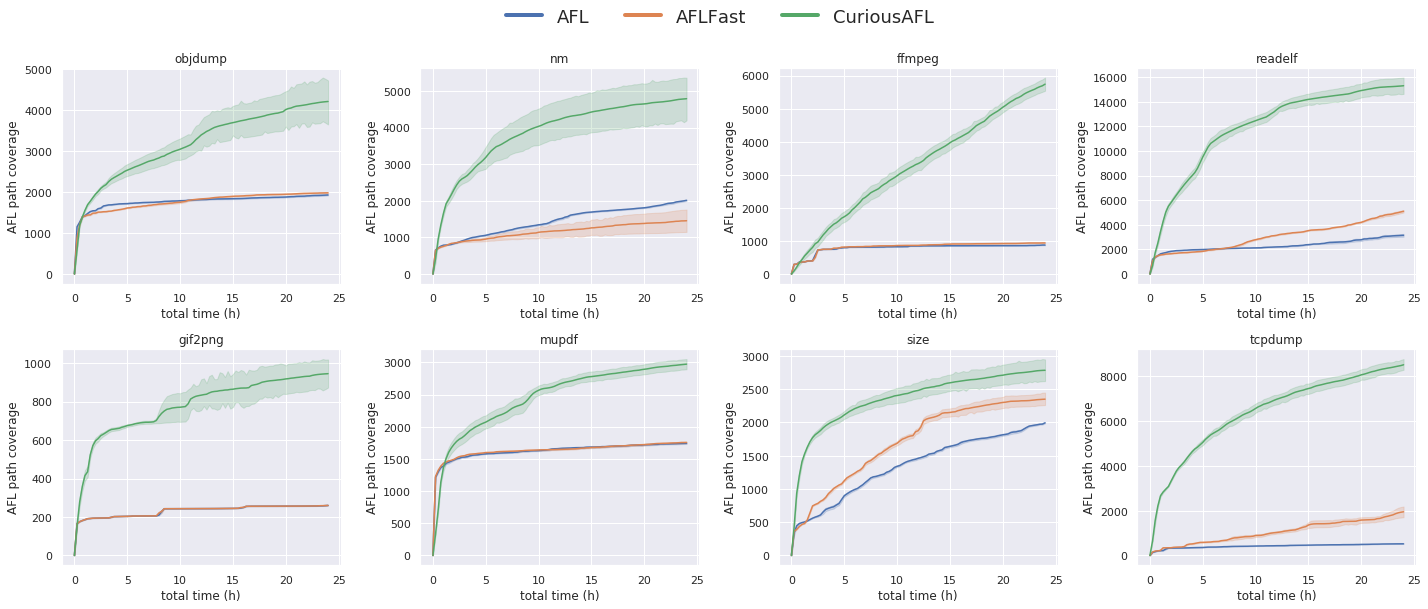

In [35]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax1,  data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax1.title.set_text('objdump')

ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2,legend=False, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax2.title.set_text('nm')

ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3,legend=False, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax3.title.set_text('ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax4,legend=False, data=results['readelf'])
ax4.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax4.title.set_text('readelf')

ax5 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax5,legend=False, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax5.title.set_text('gif2png')

ax6 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax6.title.set_text('mupdf')

ax7 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
ax7.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax7.title.set_text('size')

ax8 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax8, legend=False, data=results['tcpdump'])
ax8.set(xlabel='total time (h)', ylabel='AFL path coverage')
ax8.title.set_text('tcpdump')

handles, labels = ax1.get_legend_handles_labels()

leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax1.get_legend().remove()

fig.tight_layout() #rrect=[0,0,1,1]

#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/24h_pathcoverage_'+ seed + '.png', dpi = 200, bbox_inches="tight")

### Calculation for significance & Multipliers  
Calculation for text reference of how much of a multiplier CuriousAFL has against AFL

In [21]:
mults = []
df = pd.DataFrame(maxes)
for program in results:
    curious = df.loc[(df.program == program) & (df.fuzzer=='CuriousAFL')]
    afl = df.loc[(df.program == program) & (df.fuzzer=='AFL')]
    mults.append(curious['paths'].mean() / afl['paths'].mean())
    print("Program: ", program, " Curious Mean: ", curious['paths'].mean(), " AFL Mean: ", afl['paths'].mean(), " mult:", curious['paths'].mean() / afl['paths'].mean())

print("Avg mult: " + str(sum(mults) / len(mults)))

Program:  objdump  Curious Mean:  4212.4  AFL Mean:  1928.4  mult: 2.1844015764364237
Program:  nm  Curious Mean:  4790.8  AFL Mean:  2013.0  mult: 2.3799304520615996
Program:  ffmpeg  Curious Mean:  5758.4  AFL Mean:  874.8  mult: 6.582533150434385
Program:  mupdf  Curious Mean:  2976.2  AFL Mean:  1743.6  mult: 1.706928194540032
Program:  tcpdump  Curious Mean:  6738.0  AFL Mean:  521.2  mult: 12.92785878741366
Program:  gif2png  Curious Mean:  945.4  AFL Mean:  260.4  mult: 3.630568356374808
Program:  size  Curious Mean:  2786.0  AFL Mean:  1998.2  mult: 1.3942548293464117
Program:  readelf  Curious Mean:  15311.2  AFL Mean:  3147.4  mult: 4.864713731969244
Avg mult: 4.458898634822071


## Random Dropout Case Study  
Part of RQ3 in Evaluation. Calculates numbers for Table V.

In [64]:
maxes = {
    'program': [],
    'fuzzer': [],
    'paths': []
}
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'tcpdump': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

if empty_seed:
    seed=''
else:
    seed='pre'
    
number_of_exec = 2

In [ ]:
for exec_name in results:
    try:    
        for trial in range(1,number_of_exec+1):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random10' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('Random10')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random20' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('Random20')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
    except:
        print('Random20 file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random30' + str(trial))
            df = pd.read_csv(resultpath)
            maxes['fuzzer'].append('Random30')
            maxes['program'].append(exec_name)
            maxes['paths'].append(df[' paths_total'].iloc[-1])
    except:
        print('Random30 file not available: ' + exec_name + ' trial: ' + str(trial))

In [ ]:
mults = []
df = pd.DataFrame(maxes)
for program in results:
    random10 = df.loc[(df.program == program) & (df.fuzzer=='Random10')]
    random20 = df.loc[(df.program == program) & (df.fuzzer=='Random20')]
    random30 = df.loc[(df.program == program) & (df.fuzzer=='Random30')]
    curious = df.loc[(df.program == program) & (df.fuzzer=='CuriousAFL')]
    
    print("Program: ", program, " Random10: ", random10['paths'].min(),
          "\t Random20: ", random20['paths'].mean(), "\t Random30: ", random30['paths'].mean())

The following produces Figure 3

In [49]:
maxes = {
    'program': [],
    'fuzzer': [],
    'paths': []
}
results = {
    'objdump': pd.DataFrame(),
    'nm': pd.DataFrame(),
    'ffmpeg': pd.DataFrame(),
    'mupdf': pd.DataFrame(),
    'tcpdump': pd.DataFrame(),
    'gif2png': pd.DataFrame(),
    'size': pd.DataFrame(),
    'readelf': pd.DataFrame()
}
empty_seed = False

if empty_seed:
    seed=''
else:
    seed='pre'
    
number_of_exec = 5

In [50]:
if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:
        for trial in range(1,2+1):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random10' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'Random', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random20' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'Random', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'random30' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'Random', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Random file not available: ' + exec_name + ' trial: ' + str(trial))

    try:
        for trial in range(1,number_of_exec+1):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'AFLFast', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,number_of_exec+1):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curiousmutation' + str(trial))
            df = pd.read_csv(resultpath)
            df = df_plotdata_resample(df, 'CuriousAFL', ' unique_crashes', 'unique_crashes')
            results[exec_name] = results[exec_name].append(df)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))
        
for exec_name in results:
    results[exec_name]['delta_time'] = results[exec_name]['delta_time'].dt.total_seconds() / 3600
#p = utest(dffinal)

Random file not available: ffmpeg trial: 2
Random file not available: size trial: 1


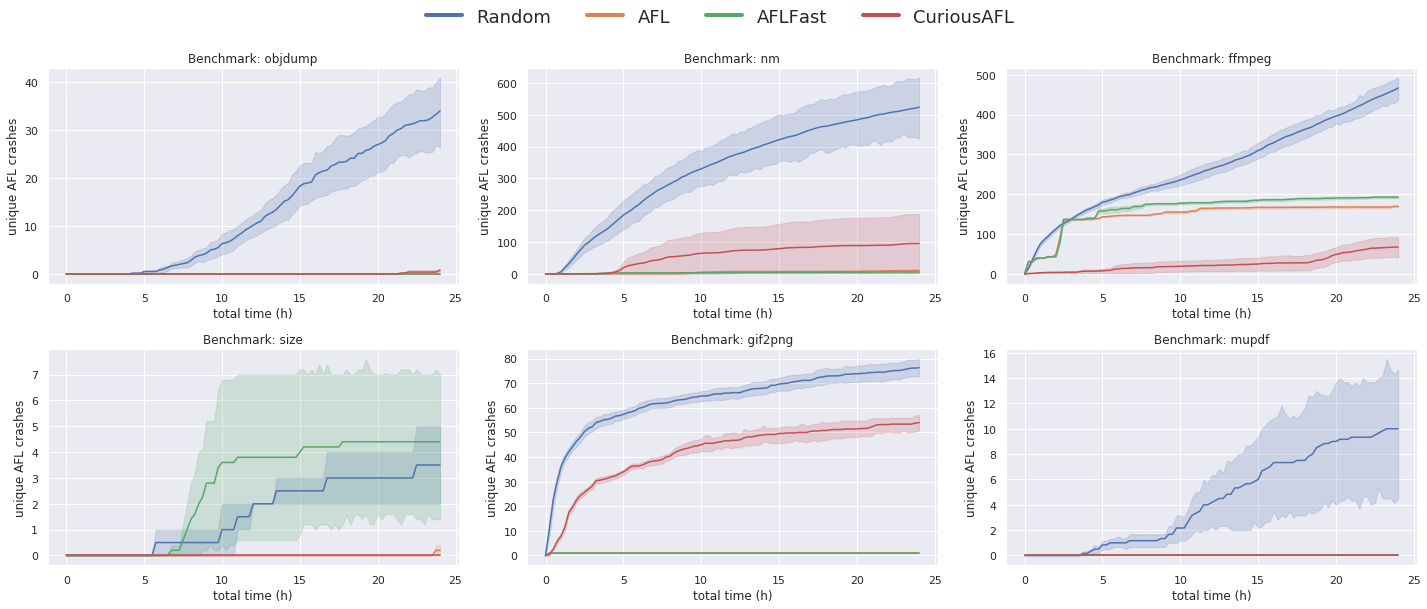

In [53]:
if empty_seed:
    seed='emptyseed'
else:
    seed='premadeseed'
    
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax1.title.set_text('Benchmark: ' + 'objdump')

ax2 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, legend=False,ax=ax2, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax2.title.set_text('Benchmark: ' + 'nm')

ax3 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax3, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax3.title.set_text('Benchmark: ' + 'ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax4, data=results['size'])
ax4.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax4.title.set_text('Benchmark: ' + 'size')

ax5 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60,legend=False, ax=ax5, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax5.title.set_text('Benchmark: ' + 'gif2png')

ax6 = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='unique AFL crashes')
ax6.title.set_text('Benchmark: ' + 'mupdf')

handles, labels = ax1.get_legend_handles_labels()

leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=4, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax1.get_legend().remove()

fig.tight_layout()

plt.savefig('./graphs/24h_randomcrashes_'+ seed + '.png', dpi = 200, bbox_inches="tight")